<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/RNN_Model_PyTorch_Dengan_Dataset_ReviewTokoBaju_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌  **RNN Model PyTorch Dengan Dataset ReviewTokoBaju.csv**


# Instalasi Library

In [4]:

!pip install torch torchvision torchaudio


# Import Library

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix




# Load Dataset

In [34]:
from IPython.display import display

file_path = '/content/ReviewTokoBaju.csv'
data = pd.read_csv(file_path)

# Menampilkan dataset dalam bentuk tabel
display(data)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


# Preprocessing

In [9]:
def clean_text_simple(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [10]:
data['Cleaned Review Text'] = data['Review Text'].apply(lambda x: clean_text_simple(str(x)))

In [11]:
data = data.dropna(subset=['Cleaned Review Text', 'Recommended IND'])

In [12]:
X = data['Cleaned Review Text']
y = data['Recommended IND']

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [16]:
X_train = X_train.toarray()
X_test = X_test.toarray()

# Split Dataset dan Convert ke Torch Tensor

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [18]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

In [19]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Build Model RNN

In [20]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x.long())  # Convert input to long tensor for embedding
        x, _ = self.rnn(x)  # Pass through RNN
        x = x[:, -1, :]  # Use the last RNN output
        x = self.fc(x)  # Fully connected layer
        x = self.sigmoid(x)  # Sigmoid activation for binary classification
        return x

In [21]:
input_dim = 5000  # Number of words in the vocabulary
hidden_dim = 128  # Number of RNN hidden units
output_dim = 1  # Binary classification (0 or 1)
model = RNNModel(input_dim, hidden_dim, output_dim)

In [22]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model RNN

In [24]:
epochs = 5
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

Epoch [1/5], Loss: 0.4676
Epoch [2/5], Loss: 0.4674
Epoch [3/5], Loss: 0.4671
Epoch [4/5], Loss: 0.4670
Epoch [5/5], Loss: 0.4673


# Evaluasi Model

In [25]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs.squeeze() > 0.5).float()  # Apply threshold for binary classification
        y_pred.extend(predictions.numpy())
        y_true.extend(labels.numpy())

In [26]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [27]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

In [28]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.8189
Precision: 0.8189
Recall: 1.0000
F1 Score: 0.9004
ROC AUC: 0.5000


# Visualisasi

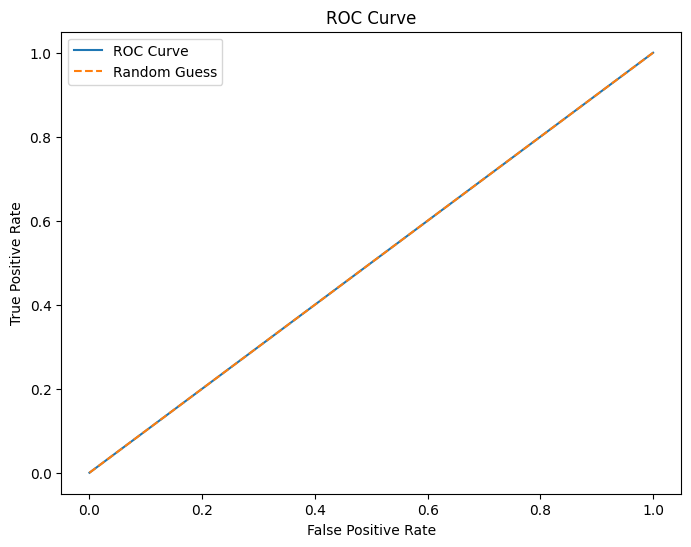

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

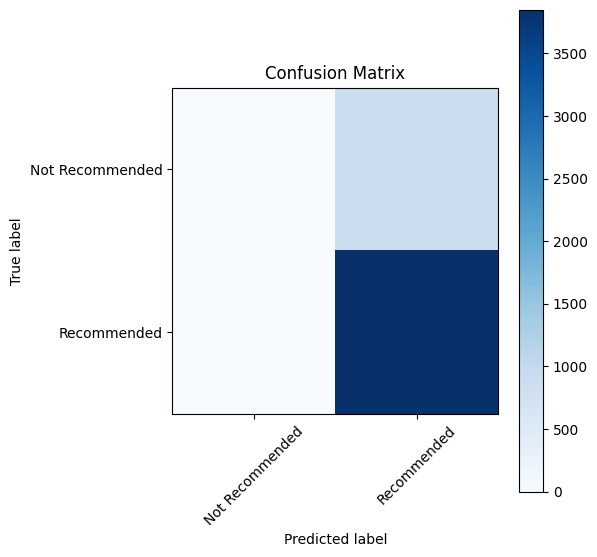

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Not Recommended', 'Recommended'], rotation=45)
plt.yticks(np.arange(2), ['Not Recommended', 'Recommended'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

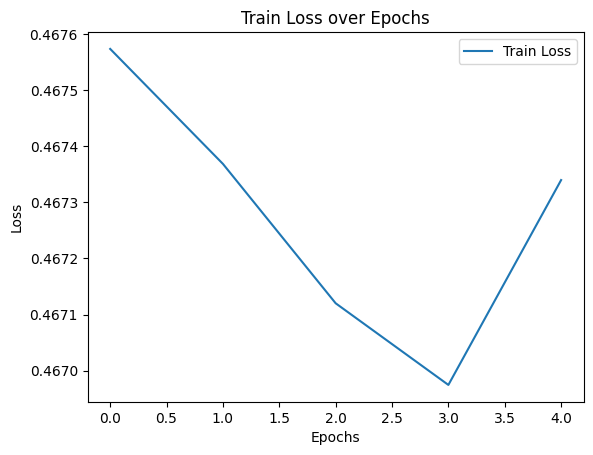

In [31]:
plt.plot(train_losses, label='Train Loss')
plt.title('Train Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
